In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # another visualization library, does correlation matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
import pydotplus # to print the tree
from IPython.display import Image
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.svm import SVR
import keras
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import cross_val_score, GridSearchCV

# Start with similar data setup steps to those seen in Notebook 1

## generate df_nonames

In [5]:
df = pd.read_csv("NewYork_Airbnb.csv") # load in the original dataset (again, it was renamed for simplicity)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## data cleaning

In [6]:
# Drop useless columns
df_nonames = df.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1)

# Fill in missing reviews-per-month values with the mean of the non-missing values from the same column
df_nonames["reviews_per_month"] = df_nonames["reviews_per_month"].fillna(np.mean(df_nonames["reviews_per_month"]))
df_nonames.dropna(inplace = True) # inplace so you don't have to declare a new variable

df_nonames.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0


## get df_under500 (Now we're restricting the range to 25 < price <= 500. This is slightly different from the df_under500 in Notebook 1!)

In [9]:
# Histogram with $500 and less
df_under500 = df_nonames[(df_nonames["price"] <= 500) & (df_nonames["price"] > 25)]
df_under500

## One-Hot Encoding df_under500 (yes, we're going to cut to the chase)

In [1]:
# WE NEED TO ONE-HOT ENCODE FIRST

# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500["room_type"], prefix = "room_type")
df_under500.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh

## Standard Scaler and Splitting (we ruled out min-max scaling, so you won't see it here)

In [56]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = StandardScaler()
X = scaler.fit_transform(X_beforescaling)

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

(33562, 230)
(11188, 230)


## Random Forest Regressor

In [57]:
# Random forest
rfr = RandomForestRegressor()
rfr = rfr.fit(X_train, y_train) # need to get X_train and y_train from directly above first

In [2]:
predictions = rfr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mae

# mae = 63.80905200152704 with df_nonames
# mae = 49.51092501233351 with df_under1k (min-max scaling)
# mae = 49.66691813298252 with df_under1k (standard scaling)... virtually no difference
# mae = 40.57083026755853 with df_under500 (standard scaling)

# mae = 45.167551003344485 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# mae = 43.44568060200669 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# mae = 42.7306906354515 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# mae = 42.269452341137125 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# mae = 42.49358193979933 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

# mae = 40.12617026954897 with df_under500_deluxe, standard scaling, random forest

# UPDATE 3/28/21: mae = 39.67 with random forest on original 10 features plus Niche rent price
# and C- airbnbs removed

In [3]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

# rmse ~ 190 with df_nonames
# rmse = 88.1 with df_under1k (min-max scaling)
# rmse = 88.2 with df_under1k (standard scaling)... virtually no difference
# rmse = 61.2 with df_under500 (standard scaling)

# rmse = 67.3 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# rmse = 65.1 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# rmse = 64.3 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# rmse = 63.6 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# rmse = 63.8 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

# rmse = 61.081503595648364 with df_under500_deluxe, standard scaling, random forest

# UPDATE 3/28/21: rmse = 60.32 with random forest on original 10 features plus Niche rent price
# and C- airbnbs removed

In [10]:
explained_variance_score(y_test, predictions)
# Random Forest:
# score was 0.13 with df_nonames
# score is now 0.45 with df_under1k
# score then became 0.52 with df_under500

# score is 0.42 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# score is 0.46 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# score is 0.47 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# score is 0.482 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# score is 0.479 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

# score is 0.509 with df_under500_deluxe, standard scaling, random forest

# UPDATE 3/28/21: score is now 0.525 with random forest on original 10 fetures plus Niche rent price
# and C- airbnbs removed

In [11]:
# this gives the mean absolute percentage error
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(predictions)))) * 100

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python

In [27]:
y_test # the correct answers (just an example)

20395    145
35423     50
9232      75
36771     70
43305    110
        ... 
28875    165
28559    219
25229     97
8845     100
4469     449
Name: price, Length: 11241, dtype: int64

In [28]:
predictions # the model's predictions (just an example)

array([198.17,  65.34,  77.08, ..., 135.83, 133.46, 287.66])

## We're going to see if neighborhood-specific data compiled from Niche.com has any effect on prices of Airbnbs within the same neighborhood(s). Load that data in here...

In [50]:
niche_data = pd.read_csv("NYC_Niche.csv")
# this is a self-created dataset compiled from search queries on Niche.com
# features are neighborhood name,
# median neighborhood rent price,
# median neighborhood-specific home value,
# neighborhood grade

In [8]:
niche_data[niche_data["Overall Grade Niche"] == "C-"] # any neighborhoods rated at C- (the worst grade)?

,Airbnb Neighborhood,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
206,West Farms,1054,392066,C-


## There is no Niche data for Navy Yard. Determine how many instances in df_under500 there are where the neighborhood is Navy Yard. (WARNING: DO NOT ENCODE df_under500 before running this cell!)

In [8]:
len(df_under500[df_under500["neighbourhood"] == "Navy Yard"])
# there are 14 such instances

14

## Here's a new idea: let's make a copy of df_under500 merged with the average price found on Niche. Then run random forest regressor (best performer) on the new features.

## You must have the original, un-encoded df_under500 in order to run this cell.

In [51]:
df_under500_deluxe = df_under500.merge(niche_data, how = 'inner', left_on = "neighbourhood",
                                       right_on = "Airbnb Neighborhood")
df_under500_deluxe.drop("Airbnb Neighborhood", axis = 1, inplace = True)
# df_under500_deluxe = df_under500_deluxe[df_under500_deluxe["Overall Grade Niche"] != "C-"]
# Drop Airbnbs in neighborhoods rated C- by Niche
df_under500_deluxe.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1551,697061,A+
1,Brooklyn,Kensington,40.64106,-73.97426,Private room,39,1,45,0.46,2,365,1551,697061,A+
2,Brooklyn,Kensington,40.64302,-73.97255,Private room,39,1,82,0.94,2,365,1551,697061,A+
3,Brooklyn,Kensington,40.64277,-73.97296,Private room,60,2,20,0.42,1,347,1551,697061,A+
4,Brooklyn,Kensington,40.64330,-73.97386,Entire home/apt,90,30,3,0.05,1,286,1551,697061,A+


In [52]:
# Are there any rows where the Niche grade is C-?
len(df_under500_deluxe[df_under500_deluxe["Overall Grade Niche"] == "C-"])

2

In [53]:
df_under500_deluxe[df_under500_deluxe["Overall Grade Niche"] == "A"]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
13228,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,148,1.200000,1,46,1776,1011398,A
13229,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,0.070000,1,0,1776,1011398,A
13230,Brooklyn,Williamsburg,40.70420,-73.93560,Entire home/apt,228,3,82,0.700000,1,140,1776,1011398,A
13231,Brooklyn,Williamsburg,40.70881,-73.95930,Entire home/apt,150,30,105,0.900000,1,30,1776,1011398,A
13232,Brooklyn,Williamsburg,40.71185,-73.96204,Private room,80,2,42,0.380000,1,263,1776,1011398,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44715,Queens,Little Neck,40.75794,-73.72956,Private room,45,1,12,0.550000,5,133,1804,668715,A
44716,Queens,Little Neck,40.75777,-73.72949,Private room,50,1,6,0.310000,5,94,1804,668715,A
44717,Queens,Little Neck,40.76212,-73.71928,Shared room,32,3,1,0.140000,1,88,1804,668715,A
44718,Queens,Little Neck,40.77122,-73.73800,Private room,100,1,0,1.373221,1,88,1804,668715,A


## get median neighborhood prices on new data subset

In [80]:
# Median Airbnb prices by neighborhood
airbnb_median_prices = df_under500_deluxe.groupby("neighbourhood")["price"].apply(np.median)
airbnb_median_prices
# airbnb_median_prices = df_under500_deluxe.reset_index()

neighbourhood
Allerton            66.5
Arden Heights       72.5
Arrochar            65.0
Arverne            120.0
Astoria             85.0
                   ...  
Willowbrook        249.0
Windsor Terrace    123.0
Woodhaven           52.0
Woodlawn            68.0
Woodside            60.0
Name: price, Length: 212, dtype: float64

## encoding df_under500_deluxe (NOW you can encode)

In [54]:
# The neighborhood, borough, and room type will be one-hot encoded

# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500_deluxe["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500_deluxe["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500_deluxe["room_type"], prefix = "room_type")
df_under500_deluxe.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500_deluxe]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh # how does the encoded dataset look?

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,n_group_Staten Island,neighborhood_Allerton,neighborhood_Arden Heights,neighborhood_Arrochar,neighborhood_Arverne,neighborhood_Astoria,...,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,0,1,0,0,0,0,0,0,0,0,...,-73.97237,149,1,9,0.210000,6,365,1551,697061,A+
1,0,1,0,0,0,0,0,0,0,0,...,-73.97426,39,1,45,0.460000,2,365,1551,697061,A+
2,0,1,0,0,0,0,0,0,0,0,...,-73.97255,39,1,82,0.940000,2,365,1551,697061,A+
3,0,1,0,0,0,0,0,0,0,0,...,-73.97296,60,2,20,0.420000,1,347,1551,697061,A+
4,0,1,0,0,0,0,0,0,0,0,...,-73.97386,90,30,3,0.050000,1,286,1551,697061,A+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44745,0,0,0,0,1,0,0,0,0,0,...,-74.21017,75,3,21,1.690000,1,59,1710,465633,B
44746,0,0,0,1,0,0,0,0,0,0,...,-73.86994,195,1,4,0.350000,2,160,99,583170,A-
44747,0,0,0,1,0,0,0,0,0,0,...,-73.87009,195,1,1,0.090000,2,59,99,583170,A-
44748,0,0,0,1,0,0,0,0,0,0,...,-73.86968,250,1,0,1.373221,1,82,99,583170,A-


## creating a dictionary for the letter grades (for visualization in a boxplot, see below)

In [55]:
grade_score = {"A+": 8, "A": 7, "A-": 6, "B+": 5, "B": 4, "B-": 3, "C+": 2, "C": 1, "C-": 0}
df_oh["Overall Grade Niche"] = df_oh["Overall Grade Niche"].replace(grade_score)

In [56]:
df_oh # now how does the encoded dataset look?

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,n_group_Staten Island,neighborhood_Allerton,neighborhood_Arden Heights,neighborhood_Arrochar,neighborhood_Arverne,neighborhood_Astoria,...,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
0,0,1,0,0,0,0,0,0,0,0,...,-73.97237,149,1,9,0.210000,6,365,1551,697061,8
1,0,1,0,0,0,0,0,0,0,0,...,-73.97426,39,1,45,0.460000,2,365,1551,697061,8
2,0,1,0,0,0,0,0,0,0,0,...,-73.97255,39,1,82,0.940000,2,365,1551,697061,8
3,0,1,0,0,0,0,0,0,0,0,...,-73.97296,60,2,20,0.420000,1,347,1551,697061,8
4,0,1,0,0,0,0,0,0,0,0,...,-73.97386,90,30,3,0.050000,1,286,1551,697061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44745,0,0,0,0,1,0,0,0,0,0,...,-74.21017,75,3,21,1.690000,1,59,1710,465633,4
44746,0,0,0,1,0,0,0,0,0,0,...,-73.86994,195,1,4,0.350000,2,160,99,583170,6
44747,0,0,0,1,0,0,0,0,0,0,...,-73.87009,195,1,1,0.090000,2,59,99,583170,6
44748,0,0,0,1,0,0,0,0,0,0,...,-73.86968,250,1,0,1.373221,1,82,99,583170,6


## do we want to drop any features?

In [ ]:
df_oh.drop(["Median Rent Price Niche"], axis = 1, inplace = True)

In [27]:
df_oh.drop(["Median Home Price Niche"], axis = 1, inplace = True)

In [ ]:
df_oh.drop(["Overall Grade Niche"], axis = 1, inplace = True)

In [12]:
# list(df_oh.columns)

In [117]:
print(encoded_grade.unique())

print(df_under500_deluxe["Overall Grade Niche"].unique())

[1. 2. 4. 0. 3. 5. 7. 6. 8.]
['A+' 'A-' 'B+' 'A' 'B' 'B-' 'C+' 'C' 'C-']


## Correlation Matrix (this was created without the numerical dictionary for Niche grade)

<AxesSubplot:>

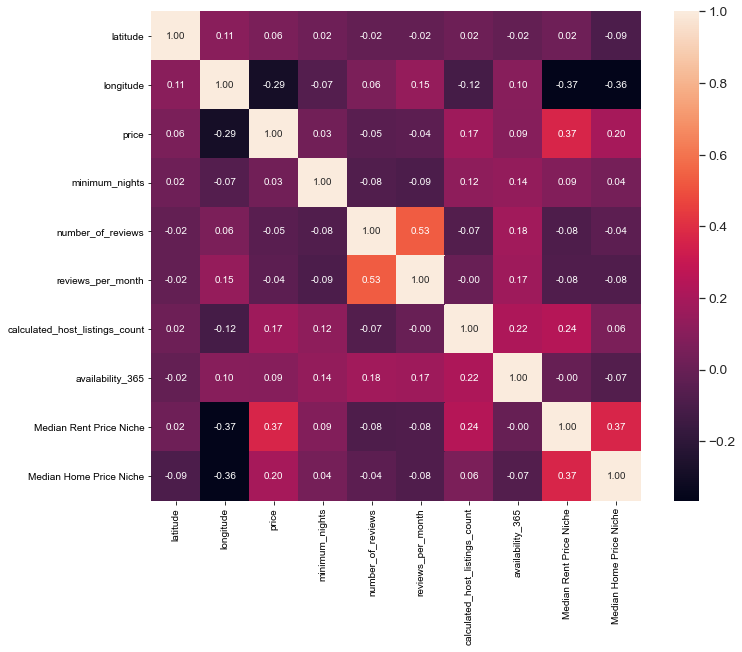

In [102]:
# correlation matrix; will tell us how each variable is related to each other
# will focus on how each variable is related to our target (price)

df_num = df_under500_deluxe.select_dtypes(include = np.number) # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
# funky formatting, 2 decimal places

## Niche grade vs Airbnb Price (the plot below was created once the dictionary was created)

In [103]:
enc.categories_

[array(['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-'], dtype=object)]

<AxesSubplot:xlabel='Overall Grade Niche', ylabel='price'>

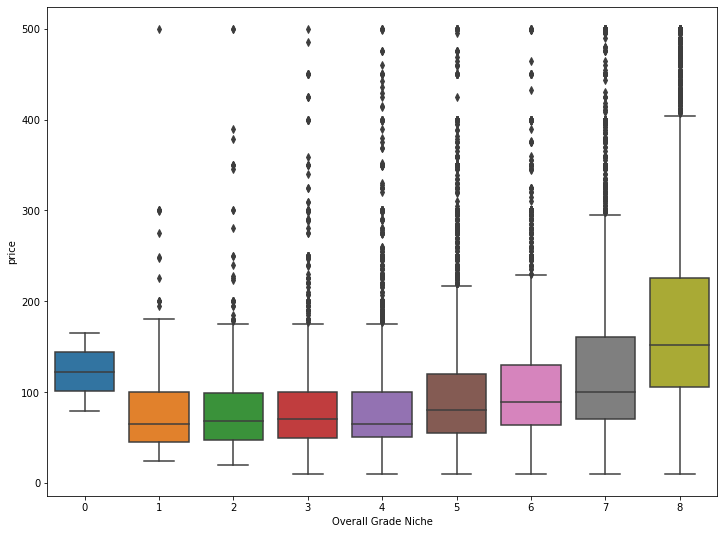

In [65]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.boxplot(x = "Overall Grade Niche", y = "price", data = df_oh, ax = ax)

# 0 = C-
# 1 = C
# 2 = C+
# 3 = B-
# 4 = B
# 5 = B+
# 6 = A-
# 7 = A
# 8 = A+

## Feature importance on df_under500_deluxe (created without the dictionary)

Feature ranking:
1. feature 7 (0.231707)
2. feature 1 (0.181278)
3. feature 0 (0.169450)
4. feature 6 (0.105500)
5. feature 4 (0.080699)
6. feature 3 (0.068477)
7. feature 2 (0.065854)
8. feature 5 (0.056909)
9. feature 8 (0.040127)


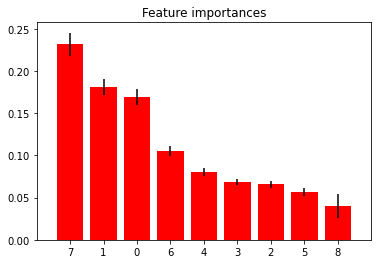

In [16]:
# Split data
X = np.array(df_under500_deluxe[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
            "calculated_host_listings_count", "availability_365", "Median Rent Price Niche", "Median Home Price Niche"]])
y = np.array(df_under500_deluxe["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365
# feature 7 = Median Rent Price Niche
# feature 8 = Median Home Price Niche

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Let's try a random forest regression on df_under500_deluxe (it needs to be encoded first, of course)

### First, standard scaling

In [8]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = StandardScaler()
X = scaler.fit_transform(X_beforescaling)

# X is just the latitude, longitude, and mean rent price on Niche

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

(35716, 234)
(11906, 234)


### Now for the Random Forest Regressor!

In [9]:
# Random forest
rfr = RandomForestRegressor()
rfr = rfr.fit(X_train, y_train) # need to get X_train and y_train from directly above first

In [10]:
predictions = rfr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE =", mae)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE =", rmse)
print(explained_variance_score(y_test, predictions))

MAE = 40.41844056218154
RMSE = 61.168146088114334
0.5244201777985802


## The mean absolute percentage error is a new, and more reliable, error metric that Prof Apthorpe suggested I consider

In [11]:
# this gives the mean absolute percentage error
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(predictions)))) * 100

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python

33.03879809571194

In [ ]:
y_test # the correct answers

In [ ]:
predictions # the model's guesses

# Feedforward Neural Network

## construct the FNN here

In [24]:
def add_layers():
    reg = Sequential()
    reg.add( Dense(units = 16, kernel_initializer = "normal", activation = "relu", input_dim = 234) )
    # adds a layer to the neural network
    # layers of size 32
    # ReLu (Rectified Linear Unit) acts like neurons, outputting values at full potential
    # the one-hot encoded df_under500 has 235 columns!
    
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    # Dropout is used for regularization, to ensure the model doesn't overfit, or over-learn
    
    reg.add( Dense(units = 8,  activation = "relu") ) # this adds a second dense layer
    # reg.add( Activation("relu") )
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    
    reg.add( Dense(units = 4,  activation = "relu") ) # this adds a third dense layer
    reg.add( Dense(units = 2,  activation = "relu") ) # this adds a fourth dense layer
#    reg.add( Dense(units = 8,  activation = "relu") ) # this adds a fourth dense layer
    
    
    reg.add( Dense(units = 1) ) # this adds the output layer (prediction)
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    reg.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])
    # this compile statement is necessary for neural networks
    # Adam is a replacement optimization algorithm for stochastic gradient descent
    # for training deep learning models.
    
    return reg

### cross-validation

In [25]:
krg = KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125)
# the data will be processed 50 lines (instances) at a time
# epochs is how many times you want the model to "learn" (and update its estimates)
# score = cross_val_score(krg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 2)

# cross-validation, no fitting

### fitting

In [13]:
hist = krg.fit(X_train, y_train, epochs = 30) # fitting, takes 1 minute

### results

In [14]:
y_pred = krg.predict(X_test) # predictions
print(y_test)
print(y_pred)

In [15]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))
r2 = r2_score(y_test, np.rint(y_pred).astype('int32'))
print("R^2 score =", r2)

In [16]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(y_pred)))) * 100
# this gives the mean absolute percentage error

## MAPE = 33.66% with df_under500_deluxe

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python